2024-06-28 20:17:16.828000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 20:17:21.945875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 20:17:49.154082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


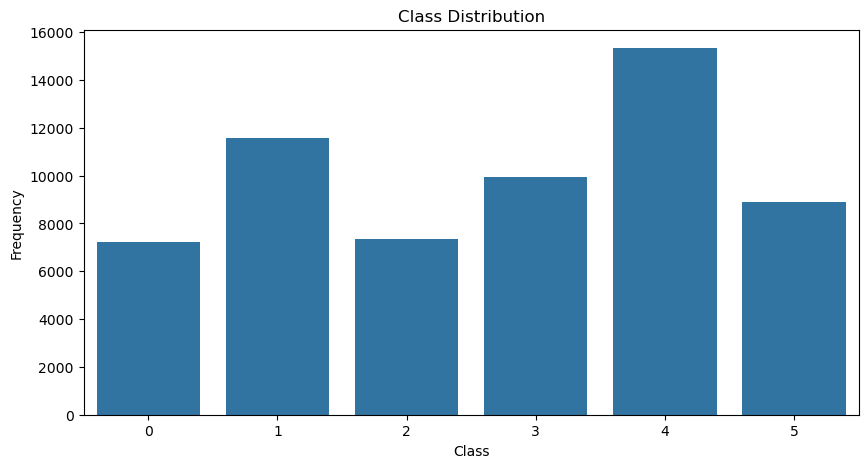

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer  # Correct import for imputation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('.').str[0].str.strip().str.upper()

    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    if merged_data.empty:
        print("No data was merged. Check cell identifiers and filters.")
        return None

    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)  # Apply imputation to handle NaNs

    return X, y, merged_data, label_encoder

metadata_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010376/normalized_GSE150949_pc9_count.csv'

X, y, merged_data, label_encoder = preprocess_data(metadata_path, data_path)

# Proceed with PCA
pca = PCA(n_components=500)
X_reduced = pca.fit_transform(X)

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))


In [2]:
def create_complex_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    x = Dense(2048, activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return autoencoder, encoder

def create_ensemble_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def model_1():
    # Define the mappings based on sample_type
    non_persister_samples = [0]
    persister_samples = ["7","3","14_high","14_med","14_low"]

    # Update labels: 0 = non-persister, 1 = persister
    y_model1 = np.where(merged_data['sample_type'].isin(persister_samples), 1, 0)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model1:", np.unique(y_model1, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model1)) != 2:
        print("Not enough classes in y_model1 for Model 1")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model1)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model1.keras')
    encoder.save('complex_encoder_model1.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model1.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Non-Persister', 'Persister']))

def model_2():
    # Define the mappings based on sample_type
    group1_samples = ['14_high']  # Dint divide
    group2_samples = ['14_med', '14_low']  # Divide

    # Update labels: 0 = Group1 (Dint divide), 1 = Group2 (Divide)
    y_model2 = np.where(merged_data['sample_type'].isin(group1_samples), 0, 1)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model2:", np.unique(y_model2, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model2)) != 2:
        print("Not enough classes in y_model2 for Model 2")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model2)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model2.keras')
    encoder.save('complex_encoder_model2.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model2.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Group1 (Dint divide)', 'Group2 (Divide)']))
    else:
        print(f"Only one class {np.unique(y_test_pred)[0]} predicted, classification report is not generated.")

# Execute Model 1
model_1()

# Execute Model 2
model_2()

Unique values in y_model1: (array([0, 1]), array([ 7226, 53089]))


2024-06-28 20:54:36.727657: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/300
664/664 - 21s - 32ms/step - loss: 1.0361 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/300
664/664 - 17s - 26ms/step - loss: 0.9986 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 3/300
664/664 - 17s - 26ms/step - loss: 0.9943 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 4/300
664/664 - 17s - 26ms/step - loss: 0.9896 - val_loss: 0.9966 - learning_rate: 0.0010
Epoch 5/300
664/664 - 17s - 26ms/step - loss: 0.9865 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 6/300
664/664 - 17s - 26ms/step - loss: 0.9838 - val_loss: 0.9910 - learning_rate: 0.0010
Epoch 7/300
664/664 - 17s - 26ms/step - loss: 0.9817 - val_loss: 0.9879 - learning_rate: 0.0010
Epoch 8/300
664/664 - 17s - 26ms/step - loss: 0.9792 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 9/300
664/664 - 17s - 26ms/step - loss: 0.9767 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 10/300
664/664 - 17s - 26ms/step - loss: 0.9744 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 11/300
664/664 - 17s - 26ms/step 